In [ ]:
!pip install -q -U "tensorflow-text==2.8.*"
!pip install -q tf-models-official==2.7.0

     |████████████████████████████████| 4.9 MB 9.1 MB/s 
     |████████████████████████████████| 462 kB 74.0 MB/s 
     |████████████████████████████████| 1.8 MB 9.3 MB/s 
     |████████████████████████████████| 99 kB 11.7 MB/s 
     |████████████████████████████████| 352 kB 67.8 MB/s 
     |████████████████████████████████| 1.2 MB 56.9 MB/s 
     |████████████████████████████████| 596 kB 63.9 MB/s 
     |████████████████████████████████| 1.1 MB 53.3 MB/s 
     |████████████████████████████████| 47.8 MB 1.8 MB/s 
     |████████████████████████████████| 43 kB 1.4 MB/s 
     |████████████████████████████████| 92 kB 6.5 MB/s 
     |████████████████████████████████| 237 kB 51.9 MB/s 


In [ ]:
import os
import shutil
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
from official.nlp import optimization
import matplotlib.pyplot as plt

tf.get_logger().setLevel('ERROR')

다운로드 하는 코드입니다. 왼쪽의 폴더 모양 아이콘을 클릭하면 aclImdb라는 폴더를 볼 수 있습니다.

In [ ]:
url = 'https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz'

dataset = tf.keras.utils.get_file('aclImdb_v1.tar.gz', url,
                                  untar=True, cache_dir='.',
                                  cache_subdir='')

dataset_dir = os.path.join(os.path.dirname(dataset), 'aclImdb')

train_dir = os.path.join(dataset_dir, 'train')

# remove unused folders to make it easier to load the data
remove_dir = os.path.join(train_dir, 'unsup')
shutil.rmtree(remove_dir)

84140032/84125825 [==============================] - 1s 0us/step


tf.data.AUTOTUNE는 prefetch에서 사용하는 파라미터입니다. 다음 링크를 보면 잘 설명되어 있습니다.

- https://www.tensorflow.org/guide/data_performance#prefetching
- https://www.tensorflow.org/api_docs/python/tf/keras/utils/text_dataset_from_directory


In [ ]:
AUTOTUNE = tf.data.AUTOTUNE
batch_size = 32
seed = 42

raw_train_ds = tf.keras.utils.text_dataset_from_directory(
    'aclImdb/train',
    batch_size=batch_size,
    validation_split=0.2,
    subset='training',
    seed=seed)

class_names = raw_train_ds.class_names
train_ds = raw_train_ds.cache().prefetch(buffer_size=AUTOTUNE)

Found 25000 files belonging to 2 classes.
Using 20000 files for training.


In [ ]:
val_ds = tf.keras.utils.text_dataset_from_directory(
    'aclImdb/train',
    batch_size=batch_size,
    validation_split=0.2,
    subset='validation',
    seed=seed)

val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

Found 25000 files belonging to 2 classes.
Using 5000 files for validation.


In [ ]:
test_ds = tf.keras.utils.text_dataset_from_directory(
    'aclImdb/test',
    batch_size=batch_size)

test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

Found 25000 files belonging to 2 classes.


In [ ]:
for text_batch, label_batch in train_ds.take(1):
  for i in range(3):
    print(f'Review: {text_batch.numpy()[i]}')
    label = label_batch.numpy()[i]
    print(f'Label : {label} ({class_names[label]})')

Review: b'"Pandemonium" is a horror movie spoof that comes off more stupid than funny. Believe me when I tell you, I love comedies. Especially comedy spoofs. "Airplane", "The Naked Gun" trilogy, "Blazing Saddles", "High Anxiety", and "Spaceballs" are some of my favorite comedies that spoof a particular genre. "Pandemonium" is not up there with those films. Most of the scenes in this movie had me sitting there in stunned silence because the movie wasn\'t all that funny. There are a few laughs in the film, but when you watch a comedy, you expect to laugh a lot more than a few times and that\'s all this film has going for it. Geez, "Scream" had more laughs than this film and that was more of a horror film. How bizarre is that?<br /><br />*1/2 (out of four)'
Label : 0 (neg)
Review: b"David Mamet is a very interesting and a very un-equal director. His first movie 'House of Games' was the one I liked best, and it set a series of films with characters whose perspective of life changes as they

사용할 수 있는 많은 BERT 모델들이 있습니다. 여기에서는 small bert를 사용합니다. 각각의 모델들에 페어링된 전처리 모델도 같이 가져와야합니다.

이름의 뜻은 다음과 같습니다.

> It uses L=4 hidden layers (i.e., Transformer blocks), a hidden size of H=512, and A=8 attention heads. For other model sizes, see the BERT collection.



In [ ]:
bert_model_name = 'small_bert/bert_en_uncased_L-4_H-512_A-8' 
tfhub_handle_encoder = 'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1'
tfhub_handle_preprocess = 'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3'

print(f'BERT model selected           : {tfhub_handle_encoder}')
print(f'Preprocess model auto-selected: {tfhub_handle_preprocess}')

BERT model selected           : https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1
Preprocess model auto-selected: https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3


Bert 사용을 위한 전처리 모델입니다.

In [ ]:
bert_preprocess_model = hub.KerasLayer(tfhub_handle_preprocess)

token이 무엇인가?

input_type_ids는 문장이 여러개인 경우에 필요하다

In [ ]:
text_test = ['this is such an amazing movie!']
text_preprocessed = bert_preprocess_model(text_test)

print(f'Keys       : {list(text_preprocessed.keys())}')
print(f'Shape      : {text_preprocessed["input_word_ids"].shape}')
print(f'Word Ids   : {text_preprocessed["input_word_ids"][0, :12]}')
print(f'Input Mask : {text_preprocessed["input_mask"][0, :12]}')
print(f'Type Ids   : {text_preprocessed["input_type_ids"][0, :12]}')

Keys       : ['input_type_ids', 'input_word_ids', 'input_mask']
Shape      : (1, 128)
Word Ids   : [ 101 2023 2003 2107 2019 6429 3185  999  102    0    0    0]
Input Mask : [1 1 1 1 1 1 1 1 1 0 0 0]
Type Ids   : [0 0 0 0 0 0 0 0 0 0 0 0]


Bert 모델입니다.

In [ ]:
bert_model = hub.KerasLayer(tfhub_handle_encoder)

In [ ]:
bert_results = bert_model(text_preprocessed)

print(f'Loaded BERT: {tfhub_handle_encoder}')
print(f'Pooled Outputs Shape:{bert_results["pooled_output"].shape}')
print(f'Pooled Outputs Values:{bert_results["pooled_output"][0, :12]}')
print(f'Sequence Outputs Shape:{bert_results["sequence_output"].shape}')
print(f'Sequence Outputs Values:{bert_results["sequence_output"][0, :12]}')

Loaded BERT: https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1
Pooled Outputs Shape:(1, 512)
Pooled Outputs Values:[ 0.76262903  0.99280983 -0.18611853  0.3667385   0.15233739  0.6550446
  0.9681154  -0.9486271   0.00216157 -0.9877732   0.06842728 -0.97630596]
Sequence Outputs Shape:(1, 128, 512)
Sequence Outputs Values:[[-0.28946295  0.34321263  0.33231527 ...  0.2130087   0.71020836
  -0.05771071]
 [-0.2874208   0.31981027 -0.23018518 ...  0.5845508  -0.21329744
   0.7269212 ]
 [-0.66157013  0.6887687  -0.8743292  ...  0.10877226 -0.26173285
   0.47855547]
 ...
 [-0.22561097 -0.2892568  -0.07064426 ...  0.47566074  0.83277184
   0.40025318]
 [-0.29824227 -0.27473107 -0.05450526 ...  0.488498    1.0955358
   0.18163362]
 [-0.4437815   0.00930744  0.07223801 ...  0.17290124  1.1833242
   0.07898009]]


여기가 핵심 부분입니다.

In [ ]:
text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
encoder_inputs = preprocessing_layer(text_input)
encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT_encoder')
outputs = encoder(encoder_inputs)

net = outputs['pooled_output']
net = tf.keras.layers.Dropout(0.1)(net)
net = tf.keras.layers.Dense(1, activation='sigmoid', name='classifier')(net)
classifier_model = tf.keras.Model(text_input, net)

In [ ]:
bert_raw_result = classifier_model(tf.constant(text_test))
print(bert_raw_result)

tf.Tensor([[0.51501375]], shape=(1, 1), dtype=float32)


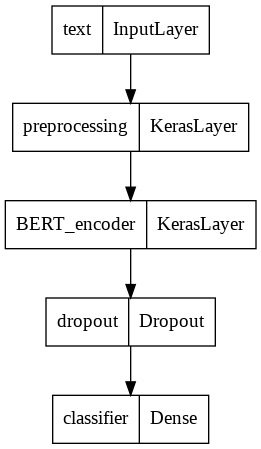

In [ ]:
tf.keras.utils.plot_model(classifier_model)

In [ ]:
classifier_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text (InputLayer)              [(None,)]            0           []                               
                                                                                                  
 preprocessing (KerasLayer)     {'input_type_ids':   0           ['text[0][0]']                   
                                (None, 128),                                                      
                                 'input_mask': (Non                                               
                                e, 128),                                                          
                                 'input_word_ids':                                                
                                (None, 128)}                                                  

최적화 문제 설정하기

In [ ]:
loss = tf.keras.losses.BinaryCrossentropy(from_logits=False)
metrics = tf.metrics.BinaryAccuracy()

In [ ]:
epochs = 5
steps_per_epoch = tf.data.experimental.cardinality(train_ds).numpy()
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1*num_train_steps)

init_lr = 3e-5
optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')

In [ ]:
classifier_model.compile(optimizer=optimizer,
                         loss=loss,
                         metrics=metrics)

In [ ]:
print(f'Training model with {tfhub_handle_encoder}')
history = classifier_model.fit(x=train_ds,
                               validation_data=val_ds,
                               epochs=epochs)

Training model with https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1
Epoch 1/5
625/625 [==============================] - 169s 260ms/step - loss: 0.4880 - binary_accuracy: 0.7505 - val_loss: 0.3879 - val_binary_accuracy: 0.8294
Epoch 2/5
625/625 [==============================] - 159s 254ms/step - loss: 0.3310 - binary_accuracy: 0.8576 - val_loss: 0.3620 - val_binary_accuracy: 0.8480
Epoch 3/5
625/625 [==============================] - 159s 254ms/step - loss: 0.2514 - binary_accuracy: 0.8957 - val_loss: 0.3860 - val_binary_accuracy: 0.8528
Epoch 4/5
625/625 [==============================] - 158s 253ms/step - loss: 0.1936 - binary_accuracy: 0.9259 - val_loss: 0.4306 - val_binary_accuracy: 0.8492
Epoch 5/5
625/625 [==============================] - 158s 253ms/step - loss: 0.1557 - binary_accuracy: 0.9420 - val_loss: 0.4822 - val_binary_accuracy: 0.8504


1. 데이터 전처리 + ML: 내 노트북
1. IMDB with RNN: https://www.tensorflow.org/text/tutorials/text_classification_rnn
1. IMDB with 사전학습 모델: https://www.tensorflow.org/tutorials/keras/text_classification_with_hub#build_the_model
1. IMDB with 사전학습 BERT 모델: https://www.tensorflow.org/text/tutorials/classify_text_with_bert

여기에 BERT는 추가 학습하지 않는 방향으로 비교 실험 해보자

In [ ]:
loss, accuracy = classifier_model.evaluate(test_ds)

print(f'Loss: {loss}')
print(f'Accuracy: {accuracy}')

782/782 [==============================] - 88s 113ms/step - loss: 0.4570 - binary_accuracy: 0.8584
Loss: 0.45704561471939087
Accuracy: 0.8583999872207642


dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])


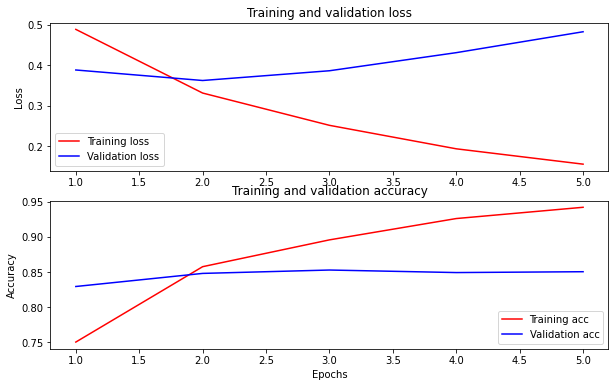

In [ ]:
history_dict = history.history
print(history_dict.keys())

acc = history_dict['binary_accuracy']
val_acc = history_dict['val_binary_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)
fig = plt.figure(figsize=(10, 6))
fig.tight_layout()

plt.subplot(2, 1, 1)
# r is for "solid red line"
plt.plot(epochs, loss, 'r', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
# plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

In [ ]:
dataset_name = 'imdb'
saved_model_path = './{}_bert'.format(dataset_name.replace('/', '_'))

classifier_model.save(saved_model_path, include_optimizer=False)

In [ ]:
reloaded_model = tf.saved_model.load(saved_model_path)

In [ ]:
def print_my_examples(inputs, results):
  result_for_printing = \
    [f'input: {inputs[i]:<30} : score: {results[i][0]:.6f}'
                         for i in range(len(inputs))]
  print(*result_for_printing, sep='\n')
  print()


examples = [
    'this is such an amazing movie!',  # this is the same sentence tried earlier
    'The movie was great!',
    'The movie was meh.',
    'The movie was okish.',
    'The movie was terrible...'
]

original_results = classifier_model(tf.constant(examples))
print_my_examples(examples, original_results)

input: this is such an amazing movie! : score: 0.999629
input: The movie was great!           : score: 0.996515
input: The movie was meh.             : score: 0.849993
input: The movie was okish.           : score: 0.023022
input: The movie was terrible...      : score: 0.000699

